In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit import QuantumCircuit
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qadence.operations import RY, RX, CNOT
import torch

In [15]:
# Differential equation parameters
lambda_ = 4
kappa = 6
u0 = 0.75

In [16]:
def chebyshev_tower_feature_map(x, num_qubits):
    """Chebyshev Tower Feature Map."""
    qc = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        angle = 2 * (i + 1) * np.arccos(x)
        qc.ry(angle, i)
    return qc

In [17]:
def evolution_enhanced_feature_map(x, num_qubits, tau):
    """Evolution-enhanced Feature Map."""
    qc = chebyshev_tower_feature_map(x, num_qubits)

    # Apply unitary evolution exp(-iHτ) with an Ising Hamiltonian (random J, h)
    J = np.random.uniform(0, 1)
    h = np.random.uniform(0, 1)

    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
        qc.ry(2 * tau * J, i)
        qc.ry(2 * tau * J, i + 1)
    
    for i in range(num_qubits):
        qc.ry(2 * tau * h, i)  # Apply rotation (Ry) for the magnetic field

    return qc

In [18]:
def variational_ansatz(qc, params, num_qubits):
    for layer in params:
        for i in range(num_qubits):
            # Apply RY gate to qubit i using the parameter from the current layer
            qc.ry(layer[i], i)
        for i in range(num_qubits - 1):
            # Apply CNOT gate for entanglement
            qc.cx(i, i + 1)

In [19]:
# Build the full quantum circuit using Qadence
def build_circuit(x, params, num_qubits, use_evolution=False, tau=2):
    if use_evolution:
        return evolution_enhanced_feature_map(x, num_qubits, tau)
    else:
        return chebyshev_tower_feature_map(x, num_qubits)

In [20]:
def quantum_model(x, params, num_qubits, use_evolution=False, tau=2):
    """Quantum Model to compute the expectation value using Qadence."""
    qc = build_circuit(x, params, num_qubits, use_evolution, tau)
    observable = SparsePauliOp.from_list([('Z' + 'I' * (num_qubits - 1), 1)])
    estimator = Estimator()  # Create an instance of the Estimator primitive
    result = estimator.run([qc], [observable]).result()
    return float(result.values[0])

In [21]:
def loss_function(params, x_values, num_qubits, use_evolution=False, tau=2):
    """Loss function for training the quantum circuit."""
    diff_loss = 0
    delta = 1e-4
    for x in x_values:
        u_x = quantum_model(x, params, num_qubits, use_evolution, tau)
        du_dx = (quantum_model(x + delta, params, num_qubits, use_evolution, tau) - u_x) / delta
        residual = du_dx - lambda_ * u_x * (kappa + np.sin(50 * x) + u_x * np.cos(25 * x)) + 1 / 2
        diff_loss += residual**2
    boundary_loss = (quantum_model(0, params, num_qubits, use_evolution, tau) - u0)**2
    total_loss = diff_loss / len(x_values) + boundary_loss
    print(f"Total Loss: {total_loss}")
    return total_loss

In [22]:
num_qubits = 6
num_layers = 5
params = np.random.uniform(0, 2 * np.pi, (num_layers, num_qubits))
x_values = np.linspace(0, 1, 100, endpoint=False)

In [23]:
def objective(flat_params, use_evolution=False, tau=2):
    reshaped_params = flat_params.reshape((num_layers, num_qubits))
    return loss_function(reshaped_params, x_values, num_qubits, use_evolution, tau)

In [24]:
flat_params = params.flatten()
result_chebyshev = minimize(objective, flat_params, args=(False, 2), method='SLSQP')
optimized_params_chebyshev = result_chebyshev.x.reshape((num_layers, num_qubits))

/tmp/ipykernel_1808224/1396094572.py:5: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()  # Create an instance of the Estimator primitive


Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437
Total Loss: 536.0119759568437


In [25]:
result_evolution = minimize(objective, flat_params, args=(True, 2), method='SLSQP')
optimized_params_evolution = result_evolution.x.reshape((num_layers, num_qubits))

/tmp/ipykernel_1808224/1396094572.py:5: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()  # Create an instance of the Estimator primitive


Total Loss: 70803613.43371893
Total Loss: 53809704.4498435
Total Loss: 63790679.060233
Total Loss: 57702914.24127029
Total Loss: 55145726.60934424
Total Loss: 64943389.77565828
Total Loss: 49176555.64755288
Total Loss: 55907437.43542041
Total Loss: 67653660.81663714
Total Loss: 61569311.415740706
Total Loss: 57598251.73618832
Total Loss: 49927269.85339731
Total Loss: 69328561.18330057
Total Loss: 54012636.13615654
Total Loss: 80186506.8841557
Total Loss: 57879122.118010506
Total Loss: 73389908.6692527
Total Loss: 49480216.6434913
Total Loss: 50192637.264328495
Total Loss: 47087187.9408037
Total Loss: 56865399.05638647
Total Loss: 79083954.72139835
Total Loss: 51723259.21323564
Total Loss: 63687716.698578335
Total Loss: 65290357.31301294
Total Loss: 50844803.887095675
Total Loss: 66423507.25723927
Total Loss: 67971561.76568536
Total Loss: 55432113.384534046
Total Loss: 59889281.8210376
Total Loss: 63264848.76982908
Total Loss: 55301612.50808331
Total Loss: 56529888.24934691
Total Loss: 

/tmp/ipykernel_1808224/1396094572.py:5: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()  # Create an instance of the Estimator primitive


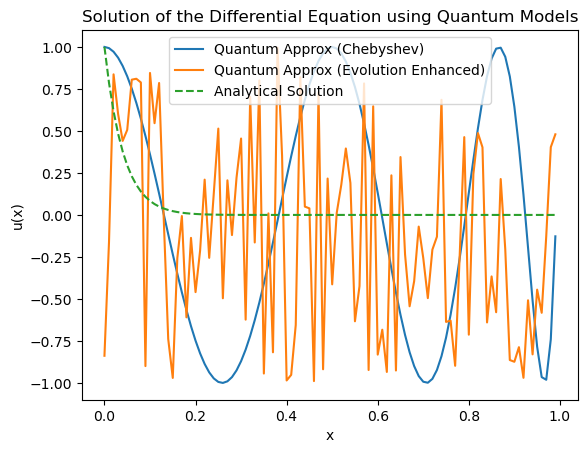

In [26]:
x_test = np.linspace(0, 1, 100, endpoint=False)
u_approx_chebyshev = [quantum_model(x, optimized_params_chebyshev, num_qubits, use_evolution=False) for x in x_test]
u_approx_evolution = [quantum_model(x, optimized_params_evolution, num_qubits, use_evolution=True) for x in x_test]

# Analytical solution (if available or approximation)
u_exact = np.exp(-kappa * lambda_ * x_test) * np.cos(lambda_ * x_test)  # Replace with the actual analytical solution

# Plot results
plt.plot(x_test, u_approx_chebyshev, label="Quantum Approx (Chebyshev)")
plt.plot(x_test, u_approx_evolution, label="Quantum Approx (Evolution Enhanced)")
plt.plot(x_test, u_exact, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title("Solution of the Differential Equation using Quantum Models")
plt.show()
